<a href="https://colab.research.google.com/github/WannJJ/Pytorch/blob/main/cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm
import time








In [3]:

mnist_dev= torchvision.datasets.MNIST('./data', train = True, download=True)
mnist_test= torchvision.datasets.MNIST('./data', train= False, download= True)

x_dev= mnist_dev.train_data /255.0
y_dev= mnist_dev.train_labels

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])
tensor(5)
True
cuda


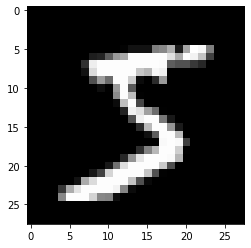

In [4]:

# MNIST consists of 60,000 28x28 images, each corresponding to a single digit (0 to 9).
print(x_dev.shape)
print(y_dev.shape)

plt.imshow(x_dev[0], cmap='gray')
print(y_dev[0])
print(torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
ntrain= 50000
x_train, y_train= x_dev[:ntrain], y_dev[:ntrain]
x_val, y_val= x_dev[ntrain:], y_dev[ntrain:]


def load_real_samples():
	# load dataset
	return [x_dev, y_dev]

In [5]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = np.random.randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = torch.ones((n_samples))
	return [X, labels], y
generate_real_samples([x_train, y_train], 10)

def generate_real_samples_fake_labels(dataset, n_samples):
    images, labels = dataset
    ix = np.random.randint(0, images.shape[0], n_samples)
    X, labels = images[ix], labels[ix]
    #generate fake labels
    labels = (labels+torch.randint(1, 9, size = (n_samples,)))%10
    y = torch.zeros((n_samples))
    return [X, labels], y

In [8]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = np.random.randint(0, n_classes, n_samples)
	return [torch.Tensor(z_input), torch.Tensor(labels).type(torch.LongTensor)]
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator(z_input.to(device), labels_input.to(device))
	# create class labels
	y = torch.zeros((n_samples))
	return [images, labels_input], y



In [9]:
class Discriminator(nn.Module):
    def __init__(self, img_size: int = 28, num_classes: int = 10):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.num_classes = num_classes
        self.embedding  = nn.Embedding(num_classes, 50)
        self.ln1 = nn.Linear(50, self.img_size*self.img_size)
        self.model = nn.Sequential(
                nn.Conv2d(2, 64, 3, stride=2), 
                nn.LeakyReLU(0.2),
                nn.Conv2d(64, 128, 3, stride=2),
                nn.LeakyReLU(0.2),
                nn.Flatten(),
                nn.Dropout(0.4),
                nn.Linear(4608, 1),
                nn.Sigmoid()
                
                )

    def forward(self, inp, labels):
        em = self.embedding(labels)
        em = self.ln1(em)
        em = em.view((-1, 1, self.img_size, self.img_size))
        im= inp.view(-1, 1, self.img_size, self.img_size)
        
        X = torch.cat([im, em], dim = 1)
        y= self.model(X)
        return y

#output size must be (-1, 1)
summary(Discriminator().model, input_size= (2, 28, 28), device= 'cpu')
model = Discriminator()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 13, 13]           1,216
         LeakyReLU-2           [-1, 64, 13, 13]               0
            Conv2d-3            [-1, 128, 6, 6]          73,856
         LeakyReLU-4            [-1, 128, 6, 6]               0
           Flatten-5                 [-1, 4608]               0
           Dropout-6                 [-1, 4608]               0
            Linear-7                    [-1, 1]           4,609
           Sigmoid-8                    [-1, 1]               0
Total params: 79,681
Trainable params: 79,681
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.31
Params size (MB): 0.30
Estimated Total Size (MB): 0.62
----------------------------------------------------------------


In [10]:
class Generator(nn.Module):
    def __init__(self,latent_dim:int = 100, num_classes: int = 10 ):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding  = nn.Embedding(num_classes, 50)
        self.ln1 = nn.Linear(50, 7*7)
        self.ln2 =  nn.Linear(latent_dim, 128*7*7)
        self.relu1 = nn.LeakyReLU(0.2)
        self.model = nn.Sequential(
                nn.ConvTranspose2d(129, 64, kernel_size= 4,stride= 2),
                nn.LeakyReLU(0.2),
                nn.ConvTranspose2d(64, 32, kernel_size= 4, stride= 2),
                nn.LeakyReLU(0.2),
                nn.Conv2d(32, 1, kernel_size= 7),
                #nn.Tanh()
                nn.Sigmoid()
                
                )
        
        
    def device(self):
        return self.parameters().device
    
    
    def forward(self, inp, labels):
        """
        input: noise/ latent vector
        
        return: fake images
        """
        label_em = self.embedding(labels)
        le = self.ln1(label_em)
        le = le.view((-1, 1, 7, 7))
        
        li = self.ln2(inp)
        li = self.relu1(li)
        li = li.view((-1, 128, 7, 7))
        X = torch.cat([li, le], dim= 1)
        
        y = self.model(X)
        return y

#output size must be (-1,1,28,28)
summary(Generator().model, input_size= (129, 7, 7), device= 'cpu')



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 64, 16, 16]         132,160
         LeakyReLU-2           [-1, 64, 16, 16]               0
   ConvTranspose2d-3           [-1, 32, 34, 34]          32,800
         LeakyReLU-4           [-1, 32, 34, 34]               0
            Conv2d-5            [-1, 1, 28, 28]           1,569
           Sigmoid-6            [-1, 1, 28, 28]               0
Total params: 166,529
Trainable params: 166,529
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.83
Params size (MB): 0.64
Estimated Total Size (MB): 1.49
----------------------------------------------------------------


In [11]:
generator = Generator()
g_opt = torch.optim.Adam(generator.parameters(), lr= 0.0002, betas= (0.5, 0.999))
discriminator = Discriminator()
d_opt = torch.optim.Adam(discriminator.parameters(), lr= 0.0002, betas= (0.5, 0.999))
loss= nn.BCELoss()

In [12]:
generator.to(device)
discriminator.to(device)

def train(dataset, latent_dim = 100, num_epoch= 100, batch_size= 256):
    for epoch in tqdm(range(num_epoch), desc= "Training"):
        x_train, y_train = dataset
        num_iter = len(x_train)//batch_size
        for _ in range(num_iter):
            discriminator.train()
            generator.train()
            
            #train discriminator on real images real labels
            d_opt.zero_grad()
            [X, label], y_real = generate_real_samples(dataset, batch_size//4)
            X, label, y_real = X.to(device), label.to(device), y_real.to(device)
            outputs= discriminator(X, label)
            d_loss1 = loss(outputs.view(-1), y_real)
            d_loss1.backward()
            d_opt.step()
            
            #train on real images fake labels
            d_opt.zero_grad()
            [X, label], y_fake =generate_real_samples_fake_labels(dataset, batch_size//4)
            X, label, y_fake = X.to(device), label.to(device), y_fake.to(device)
            outputs2= discriminator(X, label)
            d_loss2 = loss(outputs2.view(-1), y_fake)
            d_loss2.backward()
            d_opt.step()
            
            d_opt.zero_grad()
            [X, label], y_fake = generate_fake_samples(generator, latent_dim, batch_size//4)
            X, label, y_fake = X.to(device), label.to(device), y_fake.to(device) 
            outputs3= discriminator(X, label)
            d_loss3 = loss(outputs3.view(-1), y_fake)
            d_loss3.backward()
            d_opt.step()
            
            #train GAN
            g_opt.zero_grad()
            [X, label], _ = generate_fake_samples(generator, latent_dim, batch_size)
            y = torch.ones((batch_size))
            X, label, y = X.to(device), label.to(device), y.to(device) 
            outputs4= discriminator(X, label)
            g_loss = loss(outputs4.view(-1), y)
            g_loss.backward()
            g_opt.step()
        
        print(f"\nDiscriminator loss: {d_loss1} {d_loss2}, {d_loss3}, Generator loss: {g_loss}")

train([x_train, y_train])


Training:   1%|          | 1/100 [00:23<39:26, 23.90s/it]


Discriminator loss: 1.000220537185669 0.3521237373352051, 0.3979593813419342, Generator loss: 1.2908568382263184


Training:   2%|▏         | 2/100 [00:47<39:02, 23.90s/it]


Discriminator loss: 0.9784654378890991 0.2922225594520569, 0.49412983655929565, Generator loss: 1.0157028436660767


Training:   3%|▎         | 3/100 [01:11<38:43, 23.95s/it]


Discriminator loss: 0.987104594707489 0.2497493028640747, 0.5108622312545776, Generator loss: 0.9961491227149963


Training:   4%|▍         | 4/100 [01:35<38:22, 23.99s/it]


Discriminator loss: 0.9535024762153625 0.23772501945495605, 0.4702094793319702, Generator loss: 1.0201443433761597


Training:   5%|▌         | 5/100 [02:00<38:01, 24.02s/it]


Discriminator loss: 0.9801121950149536 0.2288825809955597, 0.5063478350639343, Generator loss: 1.0074673891067505


Training:   6%|▌         | 6/100 [02:24<37:37, 24.01s/it]


Discriminator loss: 0.9172629117965698 0.23069027066230774, 0.4543520510196686, Generator loss: 1.113702654838562


Training:   7%|▋         | 7/100 [02:48<37:13, 24.01s/it]


Discriminator loss: 0.7911808490753174 0.18641656637191772, 0.469290554523468, Generator loss: 1.0927504301071167


Training:   8%|▊         | 8/100 [03:12<36:48, 24.00s/it]


Discriminator loss: 0.8573707938194275 0.17371398210525513, 0.4920818507671356, Generator loss: 1.1130716800689697


Training:   9%|▉         | 9/100 [03:35<36:23, 24.00s/it]


Discriminator loss: 0.7484965324401855 0.16837981343269348, 0.510808527469635, Generator loss: 1.0476136207580566


Training:  10%|█         | 10/100 [04:00<36:00, 24.01s/it]


Discriminator loss: 0.7787642478942871 0.15402492880821228, 0.5208225250244141, Generator loss: 1.0757203102111816


Training:  11%|█         | 11/100 [04:24<35:36, 24.01s/it]


Discriminator loss: 0.7671620845794678 0.15636879205703735, 0.5345878601074219, Generator loss: 1.077445149421692


Training:  12%|█▏        | 12/100 [04:48<35:13, 24.01s/it]


Discriminator loss: 0.7883943319320679 0.23251762986183167, 0.4399566054344177, Generator loss: 1.2041822671890259


Training:  13%|█▎        | 13/100 [05:12<34:49, 24.02s/it]


Discriminator loss: 0.7369450926780701 0.12438136339187622, 0.4357309341430664, Generator loss: 1.0992497205734253


Training:  14%|█▍        | 14/100 [05:36<34:26, 24.03s/it]


Discriminator loss: 0.8979266285896301 0.12281979620456696, 0.5250025987625122, Generator loss: 1.091848611831665


Training:  15%|█▌        | 15/100 [06:00<34:02, 24.03s/it]


Discriminator loss: 0.8083933591842651 0.1644098162651062, 0.5161689519882202, Generator loss: 1.091080665588379


Training:  16%|█▌        | 16/100 [06:24<33:39, 24.04s/it]


Discriminator loss: 0.7639378905296326 0.15174388885498047, 0.6032412052154541, Generator loss: 1.0448235273361206


Training:  17%|█▋        | 17/100 [06:48<33:14, 24.04s/it]


Discriminator loss: 0.8370200991630554 0.13238543272018433, 0.503339409828186, Generator loss: 1.103947639465332


Training:  18%|█▊        | 18/100 [07:12<32:50, 24.03s/it]


Discriminator loss: 0.9340483546257019 0.1534789502620697, 0.54366534948349, Generator loss: 1.0320720672607422


Training:  19%|█▉        | 19/100 [07:36<32:26, 24.03s/it]


Discriminator loss: 0.9150856733322144 0.13956724107265472, 0.5801786184310913, Generator loss: 0.9616338014602661


Training:  20%|██        | 20/100 [08:00<32:02, 24.03s/it]


Discriminator loss: 0.9577438831329346 0.1718711256980896, 0.630212664604187, Generator loss: 0.9227126836776733


Training:  21%|██        | 21/100 [08:24<31:38, 24.03s/it]


Discriminator loss: 0.8267452716827393 0.12555427849292755, 0.5767213702201843, Generator loss: 0.9541332721710205


Training:  22%|██▏       | 22/100 [08:48<31:14, 24.03s/it]


Discriminator loss: 0.8587324619293213 0.10725655406713486, 0.6230934858322144, Generator loss: 0.928056001663208


Training:  23%|██▎       | 23/100 [09:12<30:50, 24.03s/it]


Discriminator loss: 0.8629424571990967 0.12026254832744598, 0.6208599209785461, Generator loss: 0.9378809928894043


Training:  24%|██▍       | 24/100 [09:36<30:26, 24.03s/it]


Discriminator loss: 0.8746179342269897 0.127350315451622, 0.57065749168396, Generator loss: 0.9435174465179443


Training:  25%|██▌       | 25/100 [10:00<30:02, 24.03s/it]


Discriminator loss: 0.9131604433059692 0.12510618567466736, 0.6050000786781311, Generator loss: 0.8936701416969299


Training:  26%|██▌       | 26/100 [10:24<29:38, 24.03s/it]


Discriminator loss: 0.8593690395355225 0.11911830306053162, 0.5994773507118225, Generator loss: 0.9083383083343506


Training:  27%|██▋       | 27/100 [10:48<29:14, 24.03s/it]


Discriminator loss: 0.8979498147964478 0.1404430866241455, 0.6302825212478638, Generator loss: 0.8560419678688049


Training:  28%|██▊       | 28/100 [11:12<28:50, 24.03s/it]


Discriminator loss: 0.9070749282836914 0.1344984471797943, 0.6328781843185425, Generator loss: 0.8859760761260986


Training:  29%|██▉       | 29/100 [11:36<28:25, 24.02s/it]


Discriminator loss: 0.8336139917373657 0.13869509100914001, 0.605441153049469, Generator loss: 0.8878887891769409


Training:  30%|███       | 30/100 [12:00<28:01, 24.03s/it]


Discriminator loss: 0.8831872940063477 0.15872153639793396, 0.6255388259887695, Generator loss: 0.8834018111228943


Training:  31%|███       | 31/100 [12:24<27:37, 24.03s/it]


Discriminator loss: 0.9060410261154175 0.11072813719511032, 0.6396392583847046, Generator loss: 0.8776782751083374


Training:  32%|███▏      | 32/100 [12:48<27:13, 24.03s/it]


Discriminator loss: 0.9073727130889893 0.10164821147918701, 0.6174747347831726, Generator loss: 0.8522961139678955


Training:  33%|███▎      | 33/100 [13:12<26:49, 24.02s/it]


Discriminator loss: 0.9399740695953369 0.16902899742126465, 0.6404221057891846, Generator loss: 0.8720980882644653


Training:  34%|███▍      | 34/100 [13:36<26:25, 24.02s/it]


Discriminator loss: 0.9514427185058594 0.11875410377979279, 0.5999202132225037, Generator loss: 0.8913038969039917


Training:  35%|███▌      | 35/100 [14:00<26:01, 24.02s/it]


Discriminator loss: 0.7642621994018555 0.1253969371318817, 0.5639489889144897, Generator loss: 0.9559141397476196


Training:  36%|███▌      | 36/100 [14:24<25:37, 24.02s/it]


Discriminator loss: 0.8215389251708984 0.12343961000442505, 0.6732615232467651, Generator loss: 0.9217861890792847


Training:  37%|███▋      | 37/100 [14:48<25:12, 24.02s/it]


Discriminator loss: 0.8162379860877991 0.10856793820858002, 0.5907065868377686, Generator loss: 0.8609308004379272


Training:  38%|███▊      | 38/100 [15:12<24:49, 24.02s/it]


Discriminator loss: 0.820382833480835 0.1118423193693161, 0.6021671295166016, Generator loss: 0.8444690108299255


Training:  39%|███▉      | 39/100 [15:36<24:24, 24.01s/it]


Discriminator loss: 0.8557170629501343 0.09892085194587708, 0.6004893183708191, Generator loss: 0.8384315967559814


Training:  40%|████      | 40/100 [16:00<24:00, 24.01s/it]


Discriminator loss: 0.798142671585083 0.09461037814617157, 0.6130449771881104, Generator loss: 0.8352465629577637


Training:  41%|████      | 41/100 [16:24<23:36, 24.01s/it]


Discriminator loss: 0.8683081865310669 0.12203336507081985, 0.6151565313339233, Generator loss: 0.8843892812728882


Training:  42%|████▏     | 42/100 [16:48<23:11, 24.00s/it]


Discriminator loss: 0.8431832790374756 0.11392241716384888, 0.6253511905670166, Generator loss: 0.8517317771911621


Training:  43%|████▎     | 43/100 [17:12<22:48, 24.01s/it]


Discriminator loss: 0.822314977645874 0.1057465672492981, 0.602758526802063, Generator loss: 0.8872116208076477


Training:  44%|████▍     | 44/100 [17:36<22:24, 24.01s/it]


Discriminator loss: 0.8228620290756226 0.11652220785617828, 0.6495792865753174, Generator loss: 0.8778126239776611


Training:  45%|████▌     | 45/100 [18:00<21:59, 24.00s/it]


Discriminator loss: 0.794439435005188 0.11616641283035278, 0.5966206789016724, Generator loss: 0.8666673302650452


Training:  46%|████▌     | 46/100 [18:24<21:36, 24.01s/it]


Discriminator loss: 0.8819891214370728 0.11102047562599182, 0.5898482799530029, Generator loss: 0.8615381717681885


Training:  47%|████▋     | 47/100 [18:48<21:12, 24.02s/it]


Discriminator loss: 0.8897087574005127 0.10179698467254639, 0.5666360259056091, Generator loss: 0.8361856937408447


Training:  48%|████▊     | 48/100 [19:12<20:48, 24.01s/it]


Discriminator loss: 0.8932725787162781 0.09557288885116577, 0.6104660034179688, Generator loss: 0.847941517829895


Training:  49%|████▉     | 49/100 [19:36<20:24, 24.00s/it]


Discriminator loss: 0.8741108179092407 0.1171615868806839, 0.6171318292617798, Generator loss: 0.8642429113388062


Training:  50%|█████     | 50/100 [20:00<19:59, 24.00s/it]


Discriminator loss: 0.8236528635025024 0.13063469529151917, 0.6085516214370728, Generator loss: 0.8611128330230713


Training:  51%|█████     | 51/100 [20:24<19:35, 23.99s/it]


Discriminator loss: 0.8891934752464294 0.10668432712554932, 0.692193865776062, Generator loss: 0.8354166746139526


Training:  52%|█████▏    | 52/100 [20:48<19:11, 23.99s/it]


Discriminator loss: 0.9248846769332886 0.12102244794368744, 0.6181135177612305, Generator loss: 0.8585106134414673


Training:  53%|█████▎    | 53/100 [21:12<18:47, 24.00s/it]


Discriminator loss: 0.7956281900405884 0.11929138004779816, 0.5922064781188965, Generator loss: 0.855830729007721


Training:  54%|█████▍    | 54/100 [21:36<18:24, 24.01s/it]


Discriminator loss: 0.8316847681999207 0.09945247322320938, 0.6346748471260071, Generator loss: 0.833328366279602


Training:  55%|█████▌    | 55/100 [22:00<18:00, 24.01s/it]


Discriminator loss: 0.8965970277786255 0.11852387338876724, 0.6746525764465332, Generator loss: 0.8155786395072937


Training:  56%|█████▌    | 56/100 [22:24<17:36, 24.00s/it]


Discriminator loss: 0.8273171186447144 0.10671985149383545, 0.592369556427002, Generator loss: 0.8236498236656189


Training:  57%|█████▋    | 57/100 [22:48<17:12, 24.01s/it]


Discriminator loss: 0.8145378232002258 0.11653274297714233, 0.6704510450363159, Generator loss: 0.823070764541626


Training:  58%|█████▊    | 58/100 [23:12<16:48, 24.01s/it]


Discriminator loss: 0.8146423101425171 0.1242375373840332, 0.6324841976165771, Generator loss: 0.8460330963134766


Training:  59%|█████▉    | 59/100 [23:36<16:25, 24.03s/it]


Discriminator loss: 0.8205760717391968 0.09035933017730713, 0.6731604337692261, Generator loss: 0.8300504088401794


Training:  60%|██████    | 60/100 [24:00<16:01, 24.03s/it]


Discriminator loss: 0.8028866648674011 0.08234421908855438, 0.6522125005722046, Generator loss: 0.802499532699585


Training:  61%|██████    | 61/100 [24:24<15:37, 24.03s/it]


Discriminator loss: 0.8755883574485779 0.1055493950843811, 0.6240477561950684, Generator loss: 0.8396358489990234


Training:  62%|██████▏   | 62/100 [24:48<15:12, 24.02s/it]


Discriminator loss: 0.8254343271255493 0.10011888295412064, 0.6382064819335938, Generator loss: 0.8323471546173096


Training:  63%|██████▎   | 63/100 [25:12<14:48, 24.02s/it]


Discriminator loss: 0.8319914937019348 0.07483195513486862, 0.6353299021720886, Generator loss: 0.838916540145874


Training:  64%|██████▍   | 64/100 [25:37<14:24, 24.02s/it]


Discriminator loss: 0.8071160316467285 0.10435225814580917, 0.6288280487060547, Generator loss: 0.8443666100502014


Training:  65%|██████▌   | 65/100 [26:00<14:00, 24.01s/it]


Discriminator loss: 0.8216459155082703 0.11160477995872498, 0.6865416765213013, Generator loss: 0.841157078742981


Training:  66%|██████▌   | 66/100 [26:25<13:36, 24.01s/it]


Discriminator loss: 0.9656482934951782 0.0870278924703598, 0.6741781234741211, Generator loss: 0.7937666177749634


Training:  67%|██████▋   | 67/100 [26:49<13:12, 24.01s/it]


Discriminator loss: 0.867782711982727 0.0932009369134903, 0.6177324652671814, Generator loss: 0.857725203037262


Training:  68%|██████▊   | 68/100 [27:13<12:48, 24.02s/it]


Discriminator loss: 0.8194541931152344 0.10278932005167007, 0.626244068145752, Generator loss: 0.83540940284729


Training:  69%|██████▉   | 69/100 [27:37<12:24, 24.02s/it]


Discriminator loss: 0.8581953048706055 0.11384010314941406, 0.664638876914978, Generator loss: 0.8287749290466309


Training:  70%|███████   | 70/100 [28:01<12:00, 24.03s/it]


Discriminator loss: 0.8764088153839111 0.08800084888935089, 0.667158842086792, Generator loss: 0.822109043598175


Training:  71%|███████   | 71/100 [28:25<11:36, 24.03s/it]


Discriminator loss: 0.8176522254943848 0.09505409002304077, 0.6140792369842529, Generator loss: 0.8252013921737671


Training:  72%|███████▏  | 72/100 [28:49<11:12, 24.03s/it]


Discriminator loss: 0.8473144769668579 0.09642524272203445, 0.637859582901001, Generator loss: 0.8318464756011963


Training:  73%|███████▎  | 73/100 [29:13<10:48, 24.02s/it]


Discriminator loss: 0.8582894206047058 0.1038006916642189, 0.6480542421340942, Generator loss: 0.7955806851387024


Training:  74%|███████▍  | 74/100 [29:37<10:24, 24.03s/it]


Discriminator loss: 0.772540271282196 0.09549804031848907, 0.6716318130493164, Generator loss: 0.8050775527954102


Training:  75%|███████▌  | 75/100 [30:01<10:00, 24.03s/it]


Discriminator loss: 0.8476322293281555 0.1068161129951477, 0.6784324645996094, Generator loss: 0.8107962608337402


Training:  76%|███████▌  | 76/100 [30:25<09:36, 24.03s/it]


Discriminator loss: 0.8698185682296753 0.09684032946825027, 0.6638617515563965, Generator loss: 0.8113175630569458


Training:  77%|███████▋  | 77/100 [30:49<09:12, 24.03s/it]


Discriminator loss: 0.8530051708221436 0.11205911636352539, 0.6712026596069336, Generator loss: 0.8435851335525513


Training:  78%|███████▊  | 78/100 [31:13<08:48, 24.04s/it]


Discriminator loss: 0.8605811595916748 0.09056131541728973, 0.6180458068847656, Generator loss: 0.8416370749473572


Training:  79%|███████▉  | 79/100 [31:37<08:24, 24.03s/it]


Discriminator loss: 0.927186131477356 0.08595316112041473, 0.6530061364173889, Generator loss: 0.8276645541191101


Training:  80%|████████  | 80/100 [32:01<08:00, 24.03s/it]


Discriminator loss: 0.8415333032608032 0.08617781102657318, 0.6588433384895325, Generator loss: 0.8226920962333679


Training:  81%|████████  | 81/100 [32:25<07:36, 24.03s/it]


Discriminator loss: 0.7868524789810181 0.10007177293300629, 0.6404163837432861, Generator loss: 0.7937334179878235


Training:  82%|████████▏ | 82/100 [32:49<07:12, 24.02s/it]


Discriminator loss: 0.8629235029220581 0.10568071901798248, 0.6454744338989258, Generator loss: 0.8044741153717041


Training:  83%|████████▎ | 83/100 [33:13<06:48, 24.02s/it]


Discriminator loss: 0.8686573505401611 0.09876666963100433, 0.626160740852356, Generator loss: 0.8041391372680664


Training:  84%|████████▍ | 84/100 [33:37<06:24, 24.03s/it]


Discriminator loss: 0.9045882821083069 0.10084322094917297, 0.657575249671936, Generator loss: 0.8152628540992737


Training:  85%|████████▌ | 85/100 [34:01<06:00, 24.03s/it]


Discriminator loss: 0.9047791957855225 0.11184612661600113, 0.6502854228019714, Generator loss: 0.816540539264679


Training:  86%|████████▌ | 86/100 [34:25<05:36, 24.03s/it]


Discriminator loss: 0.7836868762969971 0.08281012624502182, 0.6339352130889893, Generator loss: 0.8352360725402832


Training:  87%|████████▋ | 87/100 [34:49<05:12, 24.03s/it]


Discriminator loss: 0.7809818387031555 0.07074780017137527, 0.64577317237854, Generator loss: 0.8324974179267883


Training:  88%|████████▊ | 88/100 [35:13<04:48, 24.03s/it]


Discriminator loss: 0.8560789823532104 0.08682543784379959, 0.586214542388916, Generator loss: 0.8032869100570679


Training:  89%|████████▉ | 89/100 [35:37<04:24, 24.03s/it]


Discriminator loss: 0.844755232334137 0.10073865950107574, 0.6475396156311035, Generator loss: 0.8195895552635193


Training:  90%|█████████ | 90/100 [36:01<04:00, 24.04s/it]


Discriminator loss: 0.9223073720932007 0.08627055585384369, 0.5954267978668213, Generator loss: 0.8322893381118774


Training:  91%|█████████ | 91/100 [36:25<03:36, 24.04s/it]


Discriminator loss: 0.8268457055091858 0.1014438346028328, 0.6512546539306641, Generator loss: 0.829930305480957


Training:  92%|█████████▏| 92/100 [36:49<03:12, 24.04s/it]


Discriminator loss: 0.8016530275344849 0.08142274618148804, 0.6537684798240662, Generator loss: 0.8228927254676819


Training:  93%|█████████▎| 93/100 [37:13<02:48, 24.03s/it]


Discriminator loss: 0.8923866152763367 0.10053062438964844, 0.6896206736564636, Generator loss: 0.8303095102310181


Training:  94%|█████████▍| 94/100 [37:37<02:24, 24.02s/it]


Discriminator loss: 0.8082503080368042 0.08422274887561798, 0.6808562874794006, Generator loss: 0.8112146854400635


Training:  95%|█████████▌| 95/100 [38:01<02:00, 24.02s/it]


Discriminator loss: 0.8392190933227539 0.08515816926956177, 0.6514731645584106, Generator loss: 0.8441137075424194


Training:  96%|█████████▌| 96/100 [38:25<01:36, 24.02s/it]


Discriminator loss: 0.8850929737091064 0.07305322587490082, 0.6158886551856995, Generator loss: 0.8013336658477783


Training:  97%|█████████▋| 97/100 [38:49<01:12, 24.01s/it]


Discriminator loss: 0.8586553335189819 0.10657836496829987, 0.6358336210250854, Generator loss: 0.8164210915565491


Training:  98%|█████████▊| 98/100 [39:13<00:48, 24.01s/it]


Discriminator loss: 0.826138973236084 0.07917377352714539, 0.6696682572364807, Generator loss: 0.788314938545227


Training:  99%|█████████▉| 99/100 [39:37<00:24, 24.01s/it]


Discriminator loss: 0.8061738014221191 0.0942176878452301, 0.6473166942596436, Generator loss: 0.7943975925445557


Training: 100%|██████████| 100/100 [40:01<00:00, 24.02s/it]


Discriminator loss: 0.8410645127296448 0.08940932154655457, 0.6711177825927734, Generator loss: 0.7842941880226135


In [13]:
def save_plot(examples, n):
	# plot images
    examples = examples.cpu().detach().numpy()
    for i in range(n * n):
		# define subplot
        plt.subplot(n, n, 1 + i)
		# turn off axis
        plt.axis('off')
		# plot raw pixel data
        plt.imshow(examples[i, 0], cmap='gray')
    plt.show()

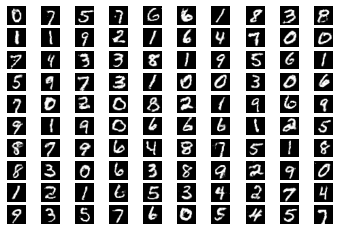

In [14]:
[fake, _ ], y = generate_fake_samples(generator, 100, 100)
plt.imshow(fake.cpu()[5][0].detach().numpy(), cmap='gray')
save_plot(fake, 10)

In [20]:
def accuracy(batch_size=200):
    X = x_val.view(-1, 1, 28, 28).repeat((1,10,1,1)).view(-1, 1, 28, 28)
    
    labels = torch.LongTensor([i for _ in range(len(x_val)) for i in range(10) ])
    batch_size = 200
    #number of samples that are correctly classified
    count = 0
    for i in range(0, len(X), batch_size):
        Xb, lb = X[i:i+batch_size], labels[i:i+batch_size]
        yb = y_val[i//10:(i+batch_size)//10]
        
        y = discriminator(Xb.to(device), lb.to(device))
        y = y.view(-1, 10).argmax(1)
        count += (y.cpu()==yb).sum()
    return   count.detach().item()/len(x_val)
accuracy()

0.9043

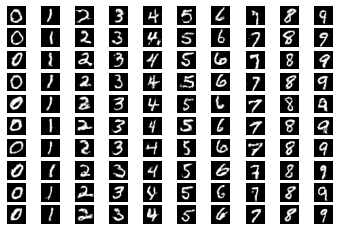

In [19]:
def show_generated_samples(latent_dim=100, n=10):
    z, _ = generate_latent_points(latent_dim, n*n)
    labels = [x for _ in range(10) for x in range(10)]
    labels = torch.Tensor(labels).type(torch.LongTensor)
    examples = generator.cpu()(z,labels)
    save_plot(examples, n)
show_generated_samples()